In [19]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.io import ascii
from astropy.io import fits

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [20]:
hdul = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
hdul.info()

data = hdul[0].data

Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   (3600, 3600)   float32   


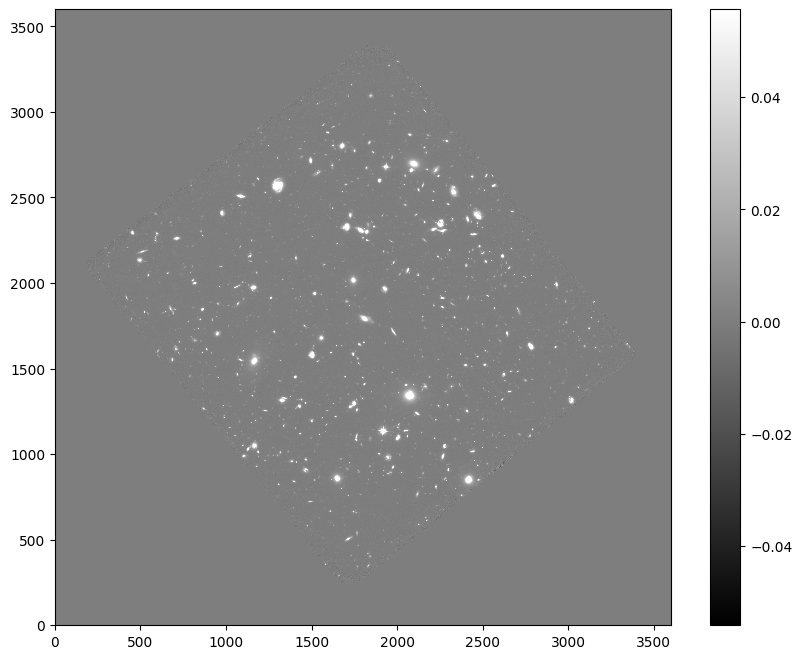

In [21]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

plt.savefig("fit-image-hubble.png",dpi=300, bbox_inches='tight')
plt.show()

In [22]:
data = data.astype(data.dtype.newbyteorder('='))

bkg = sep.Background(data)

In [23]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [24]:
bkg_image = bkg.back()

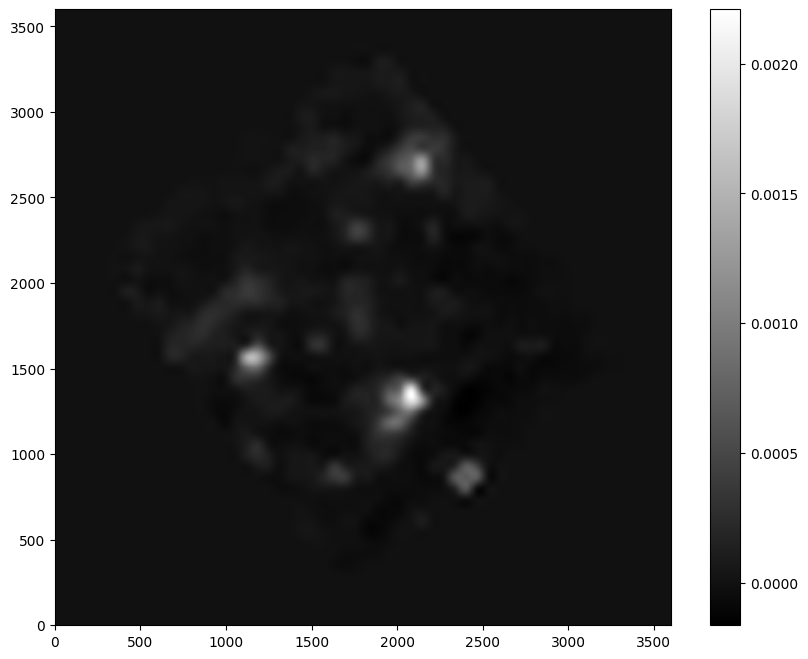

In [25]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig("background-noise-of-the-fit.png",dpi=300, bbox_inches='tight')
plt.show()

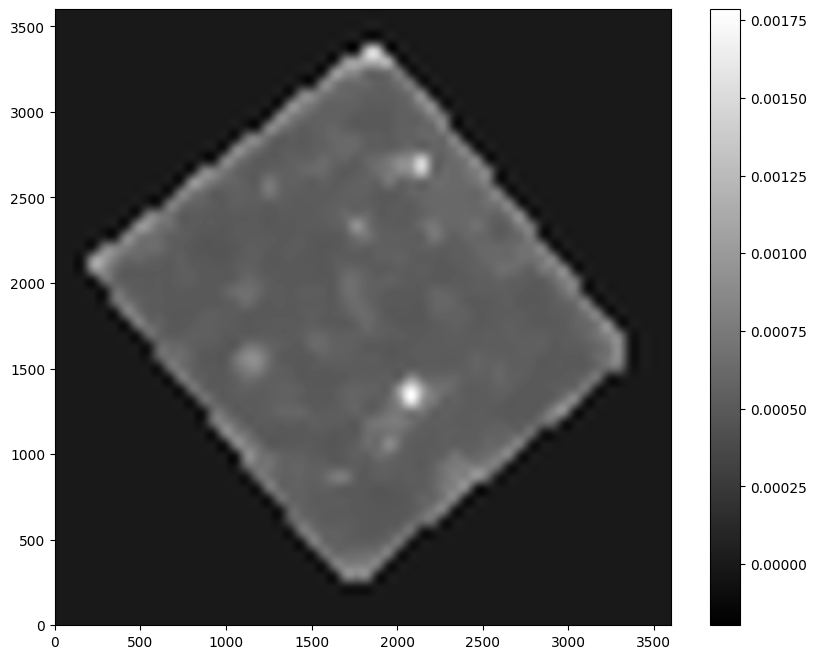

In [26]:
bkg_rms = bkg.rms()

#show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig("evaluation-of-the-background-noise.png",dpi=300, bbox_inches='tight')
plt.show()

In [27]:
data_sub = data - bkg

In [28]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

len(objects)

8630

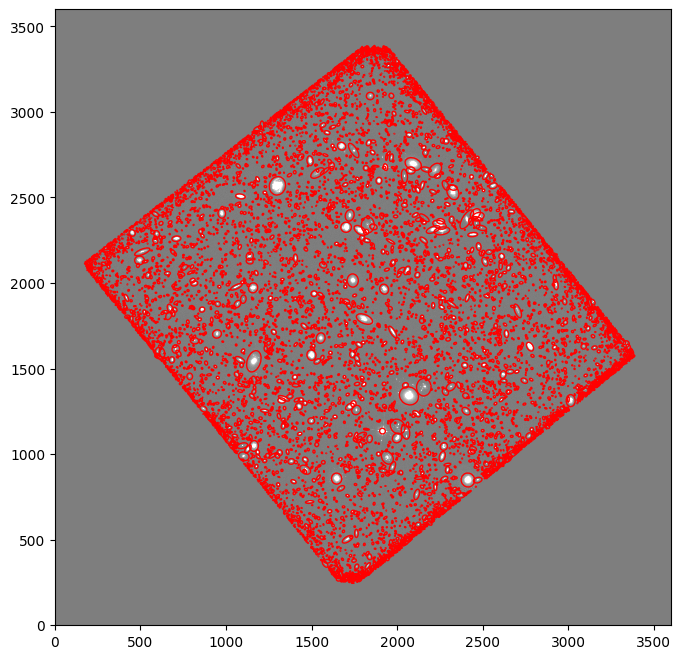

In [29]:
from matplotlib.patches import Ellipse

#plot background-subtracted image

fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

#plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig("objects-in-the-sky.png",dpi=300, bbox_inches='tight')
plt.show()

In [30]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [31]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

#showing the first 10 object results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


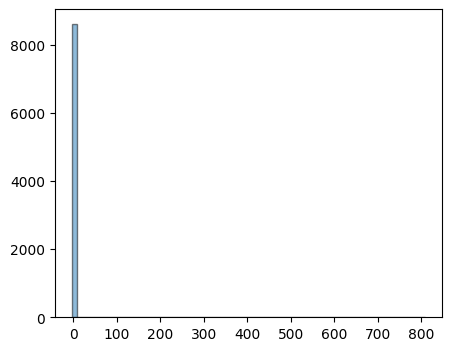

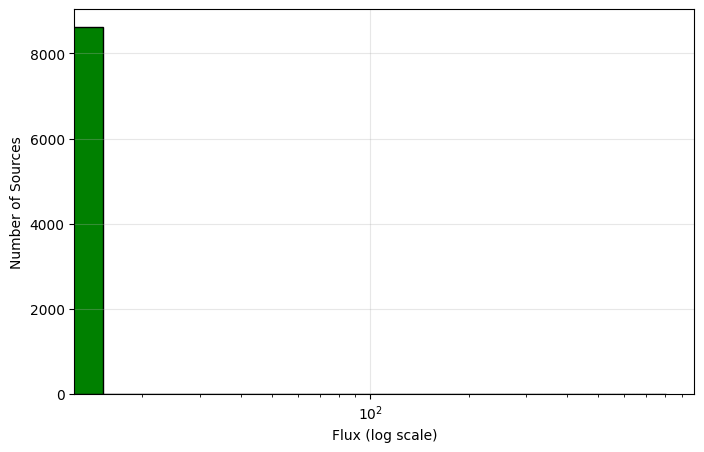

In [33]:
#creating the histogram

std = np.std(flux)
#this shows us the flux standard deviation

insc = (pow(std, 2) - pow(0.25, 2)) ** 0.5

#data before trying to make it clearer

width = 10
plt.figure(figsize=(5,4))
histmin = np.floor(min(flux))
histmax = np.ceil(max(flux)) + width
bins = np.arange(histmin, histmax, width)
plt.hist(flux, bins=bins, alpha=0.5, edgecolor='black')


plt.figure(figsize=(8,5))
plt.hist(flux, bins=50, color='green', edgecolor='black')
plt.xscale('log')
plt.xlabel('Flux (log scale)')
plt.ylabel('Number of Sources')
plt.grid(alpha=0.3)
plt.show()

#ask how to change the data to be nicer looking


In [34]:
sources = sep.extract(data_sub, thresh=3.0)
fluxes = sources['flux']

mean_flux = np.mean(fluxes)
median_flux = np.median(fluxes)
std_flux = np.std(fluxes)

print("Mean of the Flux =",mean_flux)
print("Median of the Flux =",median_flux)
print("Standard deviation of the flux =", std_flux)

z_scores = (fluxes - mean_flux) / std_flux

idx = np.argmax(np.abs(z_scores))

flux_largest_outlier = fluxes[idx]
largest_outlier_position = (sources['x'][idx], sources['y'][idx])
largest_outlier_sigma = z_scores[idx]

print("Largest outlier flux:", flux_largest_outlier)
print("Outlier position:", largest_outlier_position)
print("How many stardard deviations from the mean:", largest_outlier_sigma)

Mean of the Flux = 258.09015464782715
Median of the Flux = 47.17279052734375
Standard deviation of the flux = 364.6071768148767
Largest outlier flux: 973.9678344726562
Outlier position: (np.float64(1914.19122069879), np.float64(1134.4613554171897))
How many stardard deviations from the mean: 1.9634218011794766


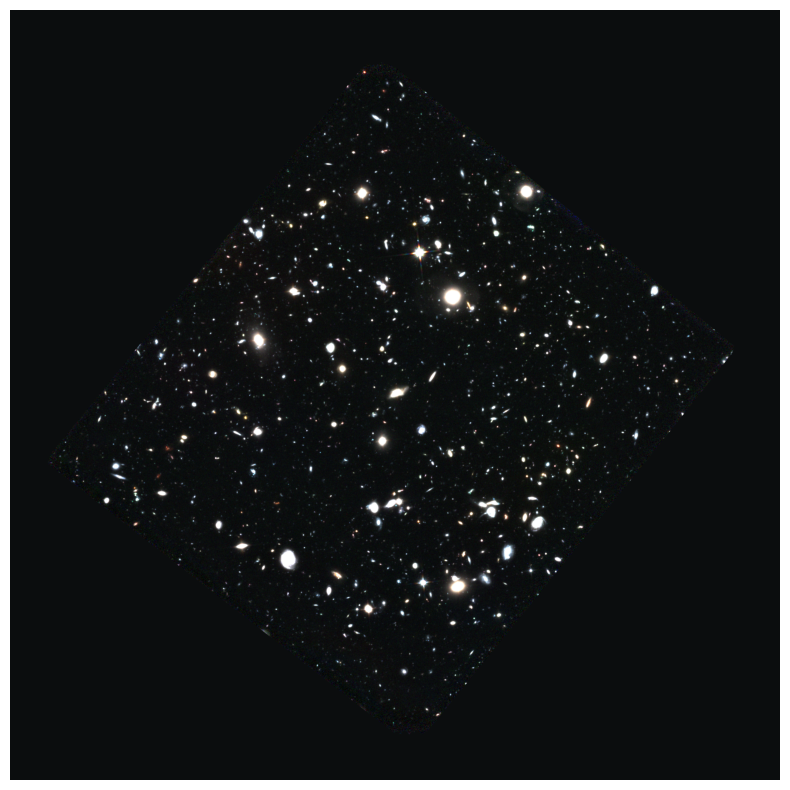

In [37]:
#opens the three images

f105w = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits").astype(float)
f125w = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits").astype(float)
f160w = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits").astype(float)

def color(img):
    lo, hi = np.percentile(img, (0.5, 99.5))
    img = np.clip((img - lo) / (hi - lo), 0, 1)
    return img
    
R = color(f160w)
G = color(f125w)
B = color(f105w)

rgb = np.dstack([R, G, B])

plt.figure(figsize=(10,10))
plt.imshow(rgb)
plt.axis("off")
plt.savefig("colorized-galaxy.png")